In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def read_csv_with_headers(filepath):

    df = pd.read_csv(filepath, names=['Policy', 'environment', 'mean', 'std'])
    if df.columns[0] != 'Policy':
        df.columns = ['Policy', 'environment', 'mean', 'std']

    df['mean'] = df['mean'].abs()  # Change negative values to positive
    df['environment'] = df['environment'].str.strip()  # Remove leading and trailing whitespaces
    df = calculate_confidence_interval(df)
    return df

def calculate_confidence_interval(df):
    df['CI'] = 1.96 * df['std'] / np.sqrt(500)
    return df

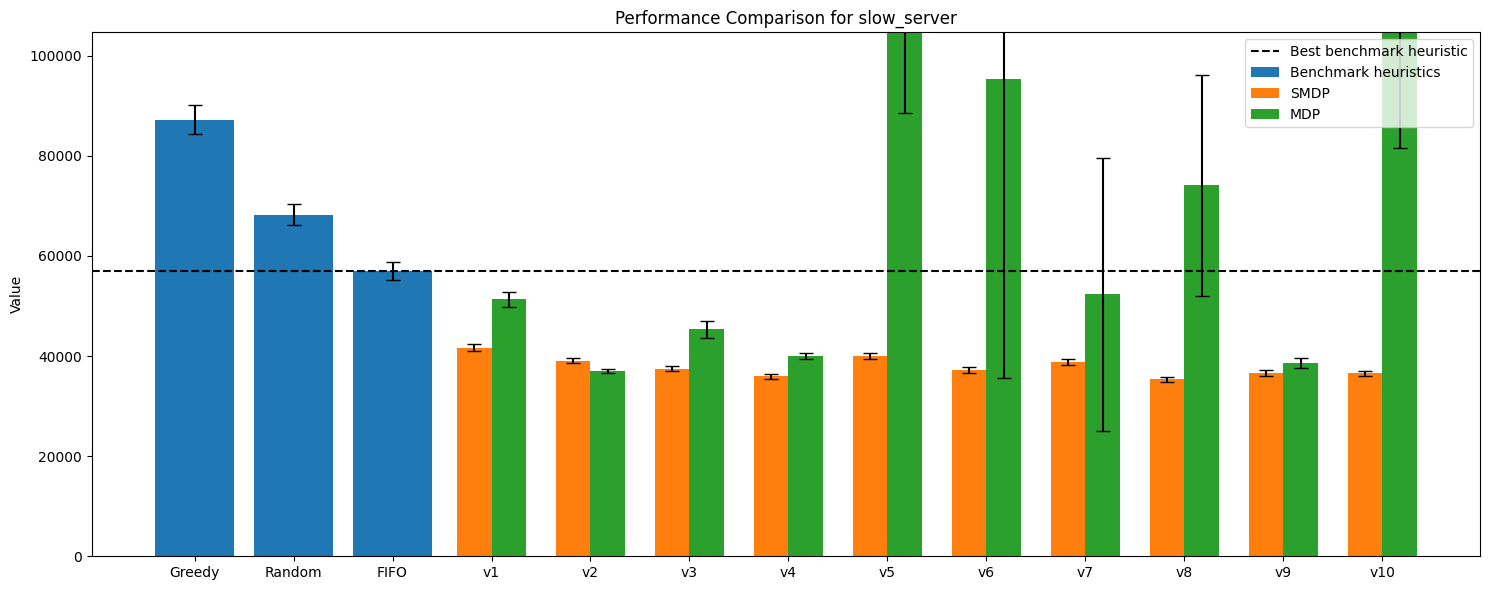

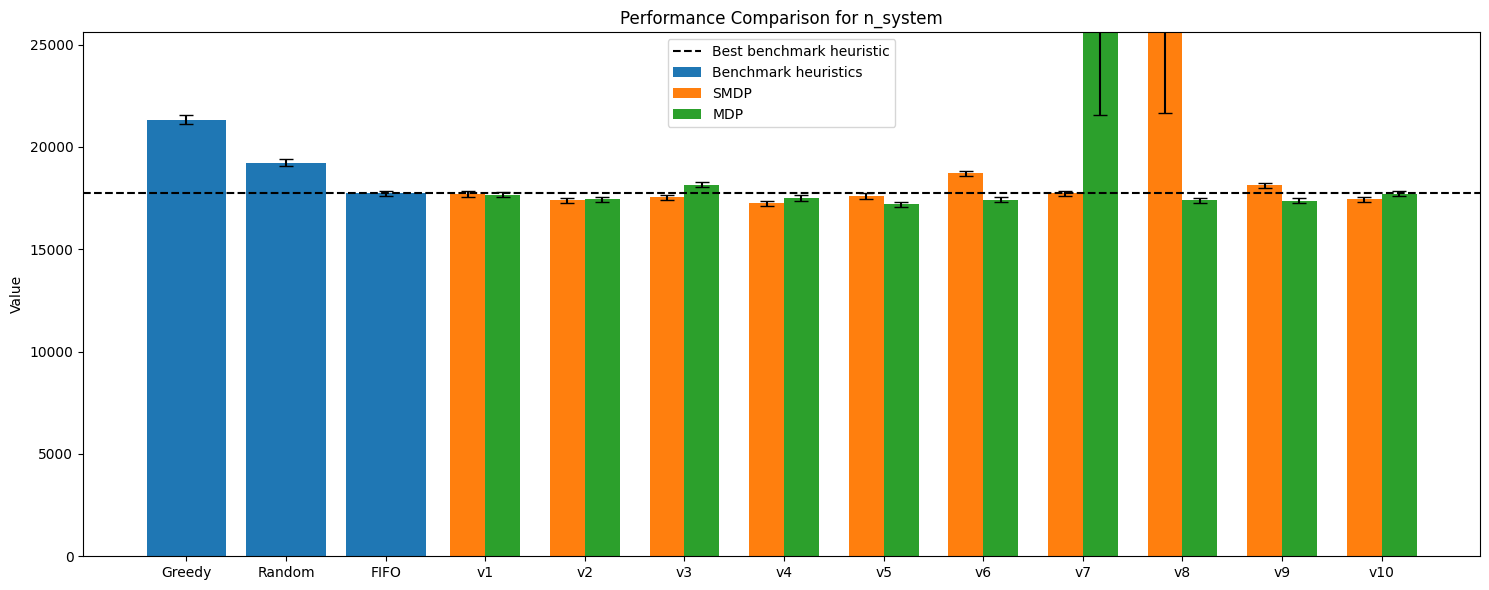

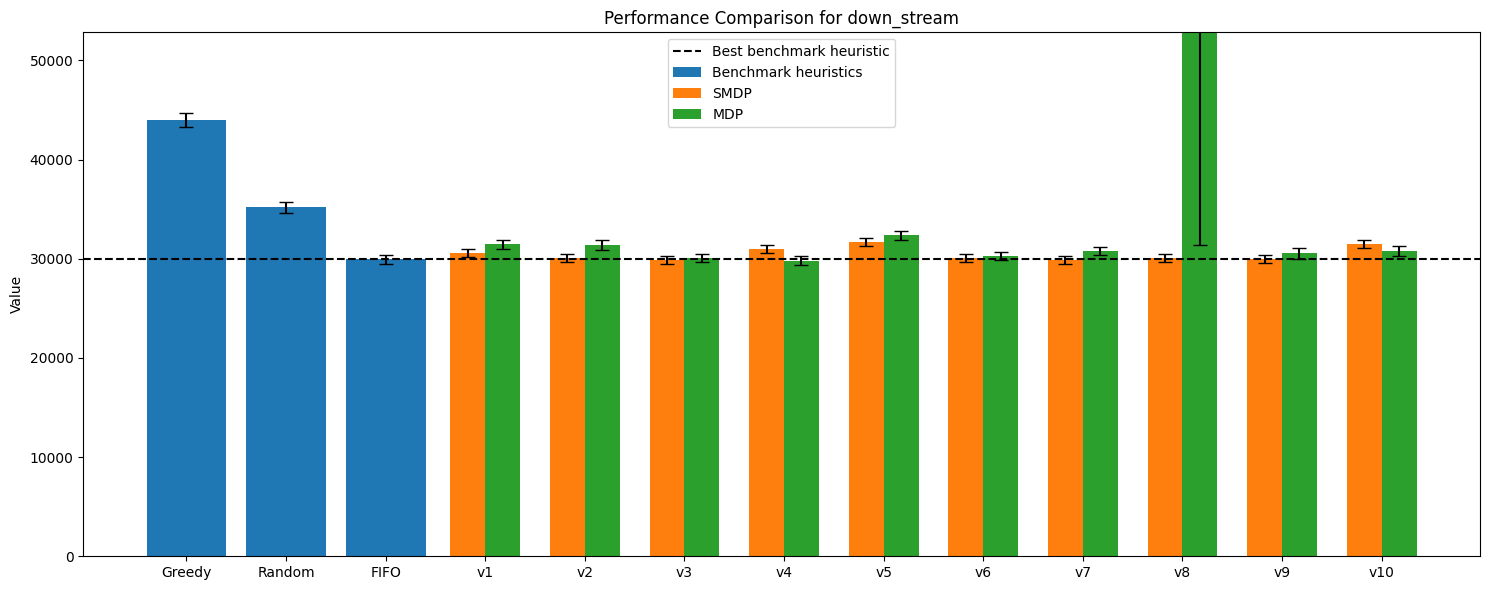

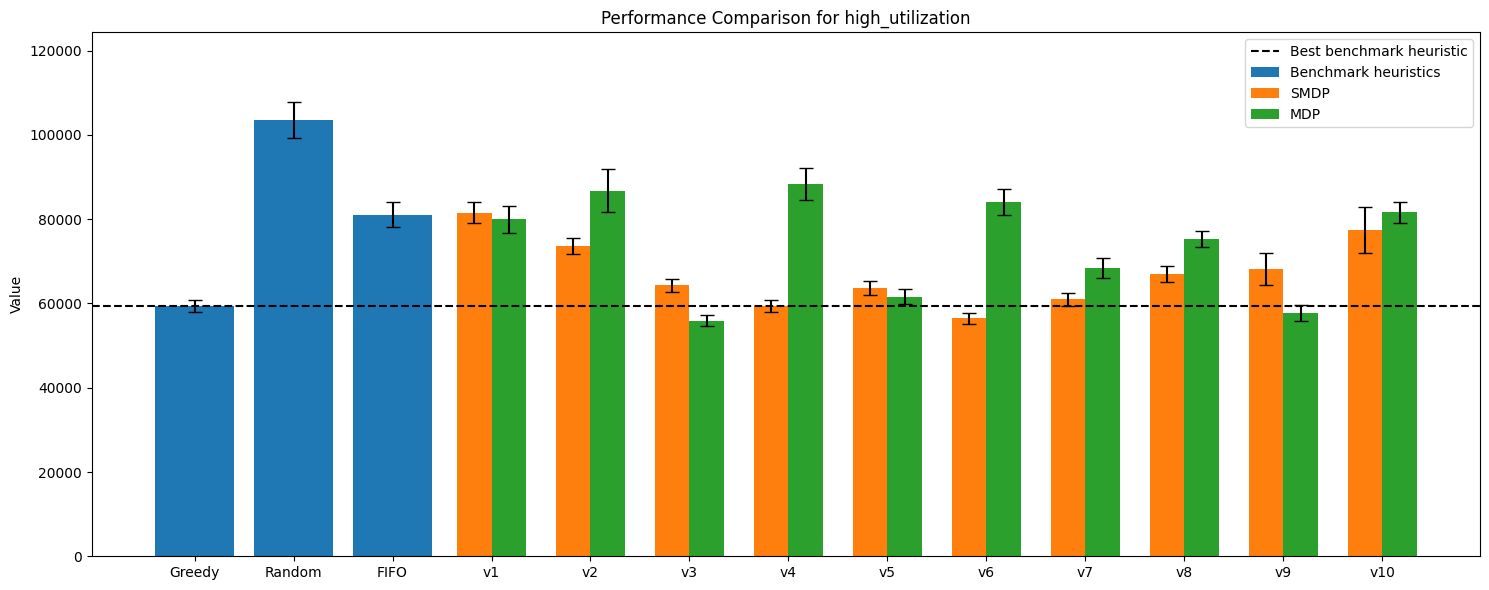

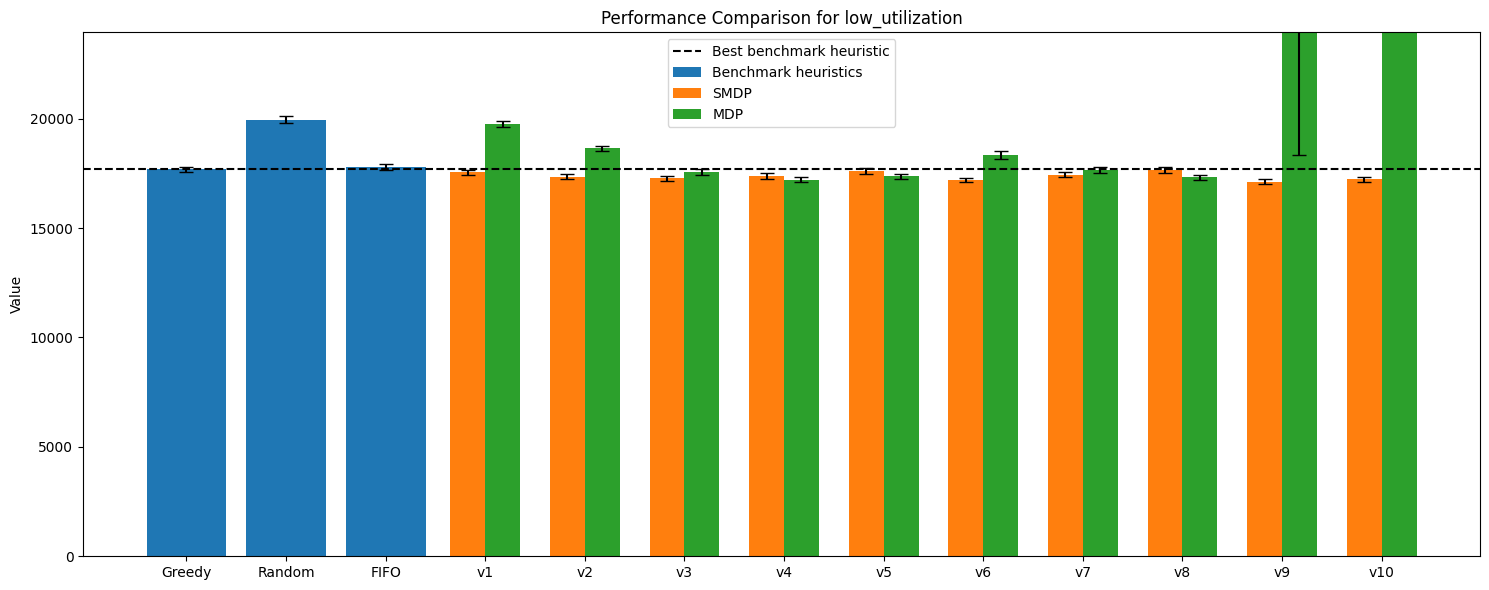

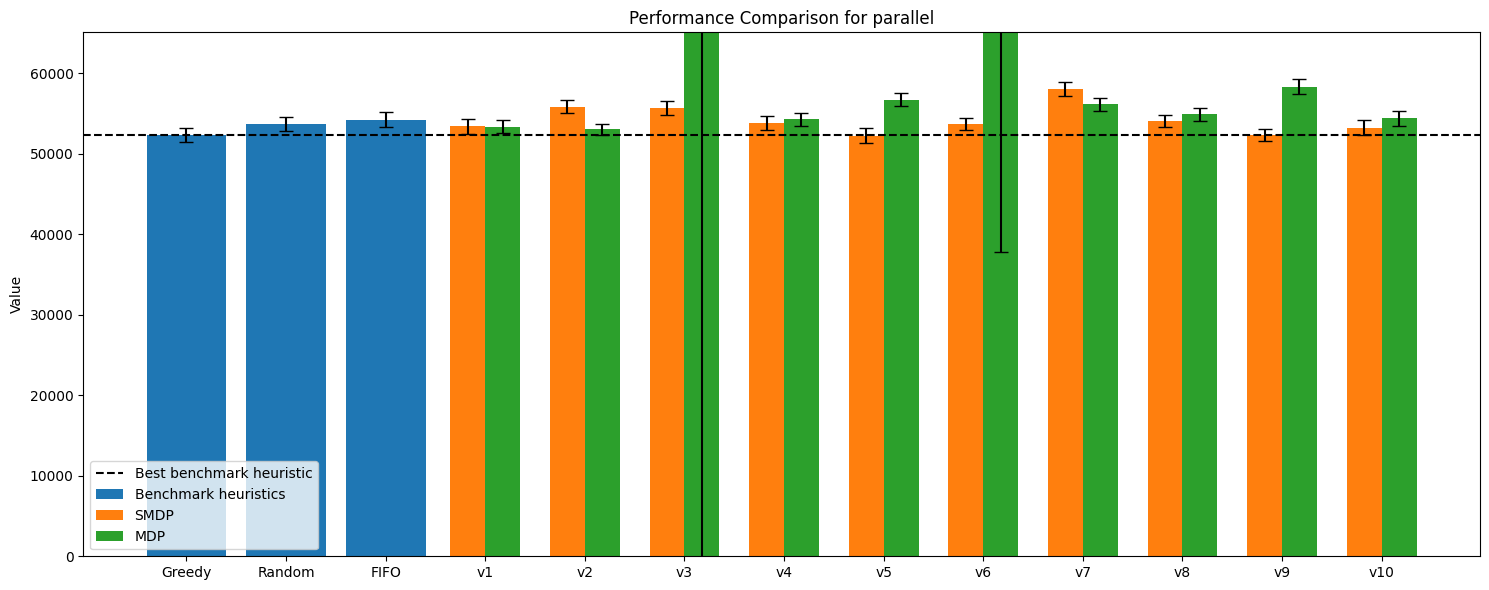

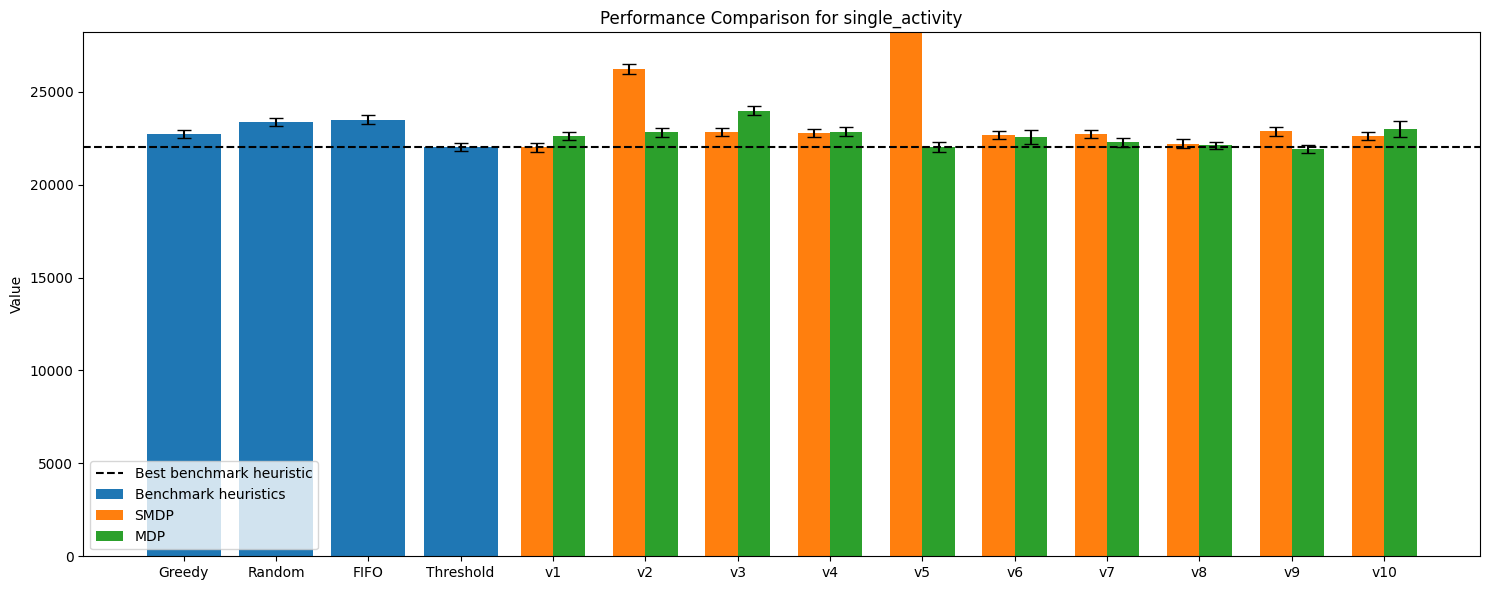

In [2]:
data = {}

configs = ["slow_server", "n_system", "down_stream", "high_utilization", "low_utilization", "parallel", "single_activity"]

for config in configs:
    df = read_csv_with_headers(f"./results/smdp/results_{config}.txt")
    policies = ['Greedy', 'Random', 'FIFO']
    if config == 'single_activity':
        policies.append('Threshold')
    for policy in policies:
        df_policy = df[df['Policy'] == policy]
        data[policy] = (df_policy['mean'].iloc[0], df_policy['CI'].iloc[0])

    for environment in ['smdp', 'mdp']:
        for v in [f'v{i}' for i in range(1, 11)]:
            #print(v, environment, v in df['Policy'].unique(), environment in df['environment'].unique())
            #print(df)
            df_learned_v = df[(df['environment'] == environment) & (df['Policy'] == v)]
            data[(environment, v)] = (df_learned_v['mean'].iloc[0], df_learned_v['CI'].iloc[0])

    # Create figure
    fig, ax = plt.subplots(figsize=(15, 6))

    # Setup x-axis positions
    versions = [f'v{i}' for i in range(1, 11)]
    width = 0.35

    # Calculate x positions
    policy_positions = np.arange(len(policies))
    version_positions = np.arange(len(versions)) + len(policies)  # +1 for spacing

    # Plot policies
    policy_means = [data[p][0] for p in policies]
    policy_errors = [data[p][1] for p in policies]
    ax.bar(policy_positions, policy_means, yerr=policy_errors, capsize=5, label='Benchmark heuristics')

    # Plot learned models
    smdp_means = [data[('smdp', v)][0] for v in versions]
    smdp_errors = [data[('smdp', v)][1] for v in versions]
    mdp_means = [data[('mdp', v)][0] for v in versions]
    mdp_errors = [data[('mdp', v)][1] for v in versions]

    ax.bar(version_positions - width/2, smdp_means, width, yerr=smdp_errors, label='SMDP', capsize=5)
    ax.bar(version_positions + width/2, mdp_means, width, yerr=mdp_errors, label='MDP', capsize=5)

    ax.axhline(y=min(policy_means), color='black', linestyle='--', label='Best benchmark heuristic')
    ax.set_ylim(0, 1.2 * max(policy_means))

    # Set x-ticks and labels
    all_positions = np.concatenate([policy_positions, version_positions])
    all_labels = policies + versions
    ax.set_xticks(all_positions)
    ax.set_xticklabels(all_labels)

    # Add labels and legend
    ax.set_ylabel('Value')
    ax.set_title(f'Performance Comparison for {config}')
    ax.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

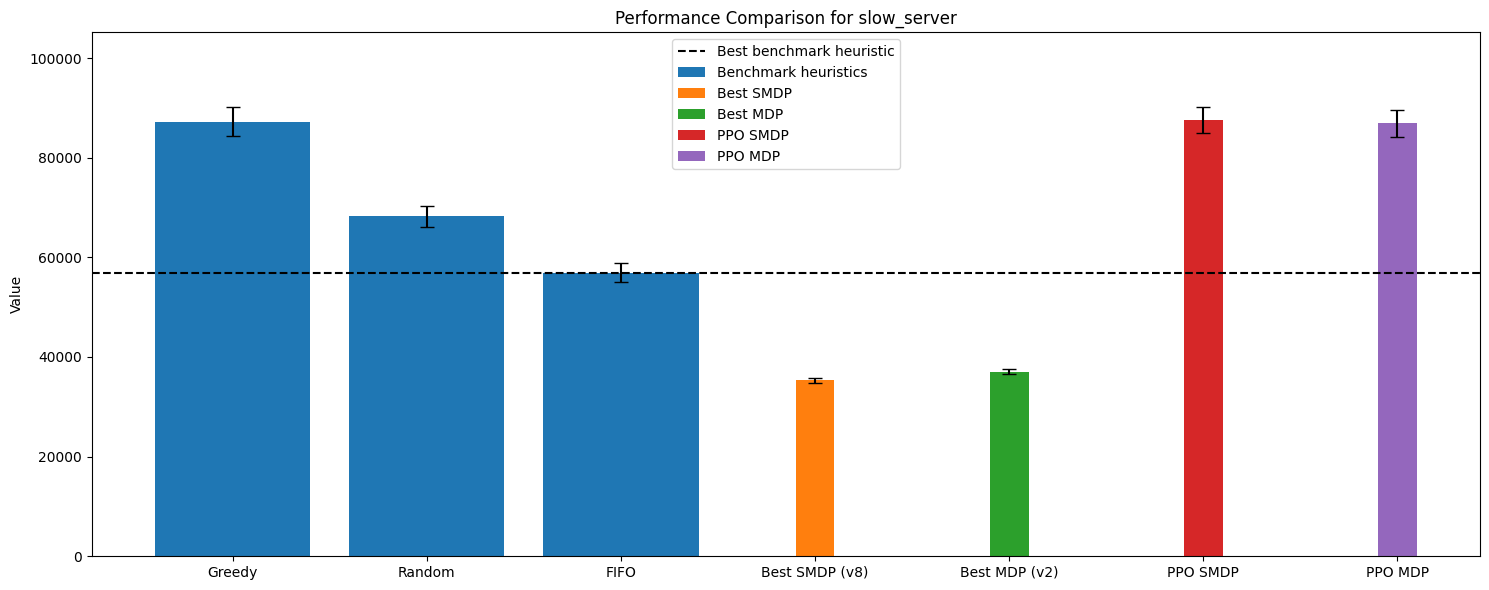

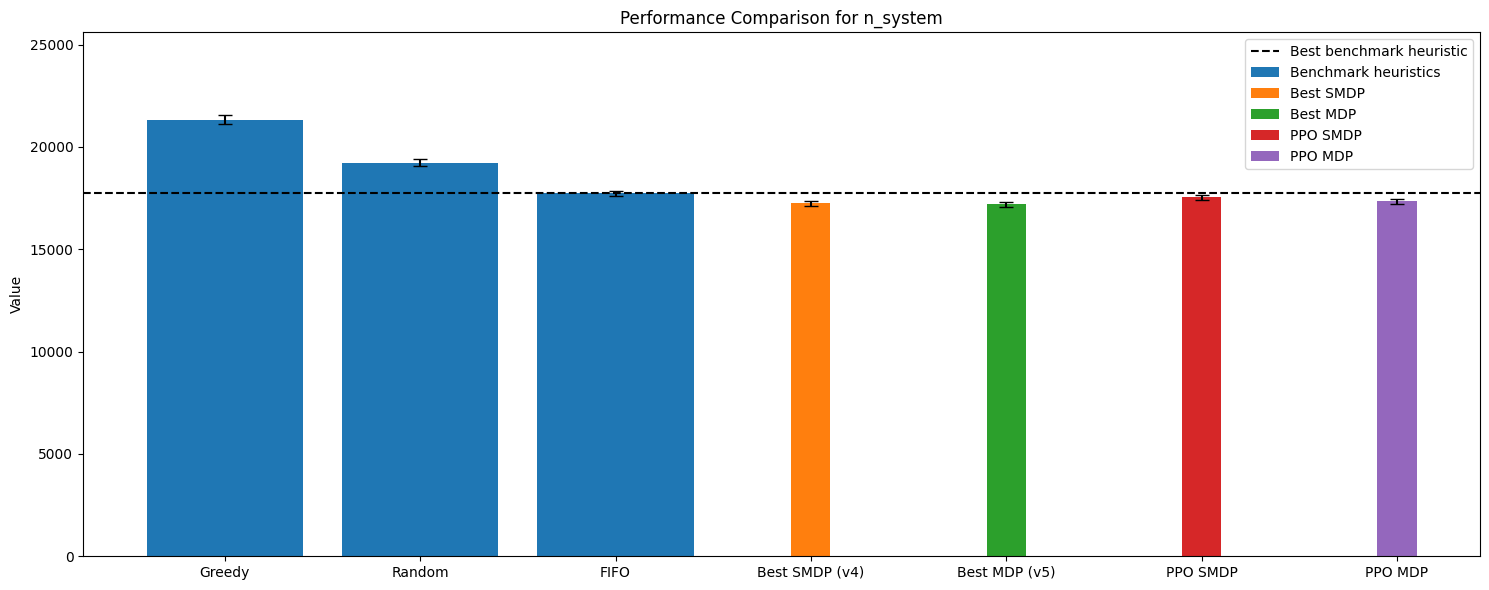

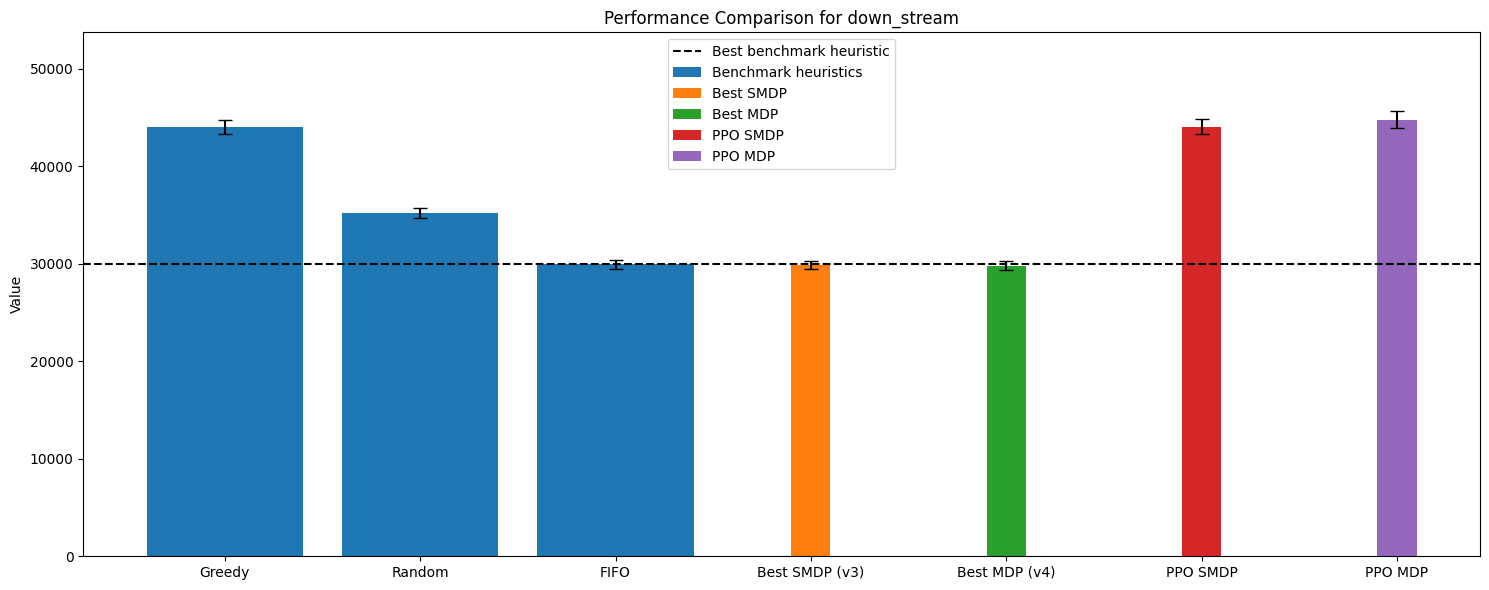

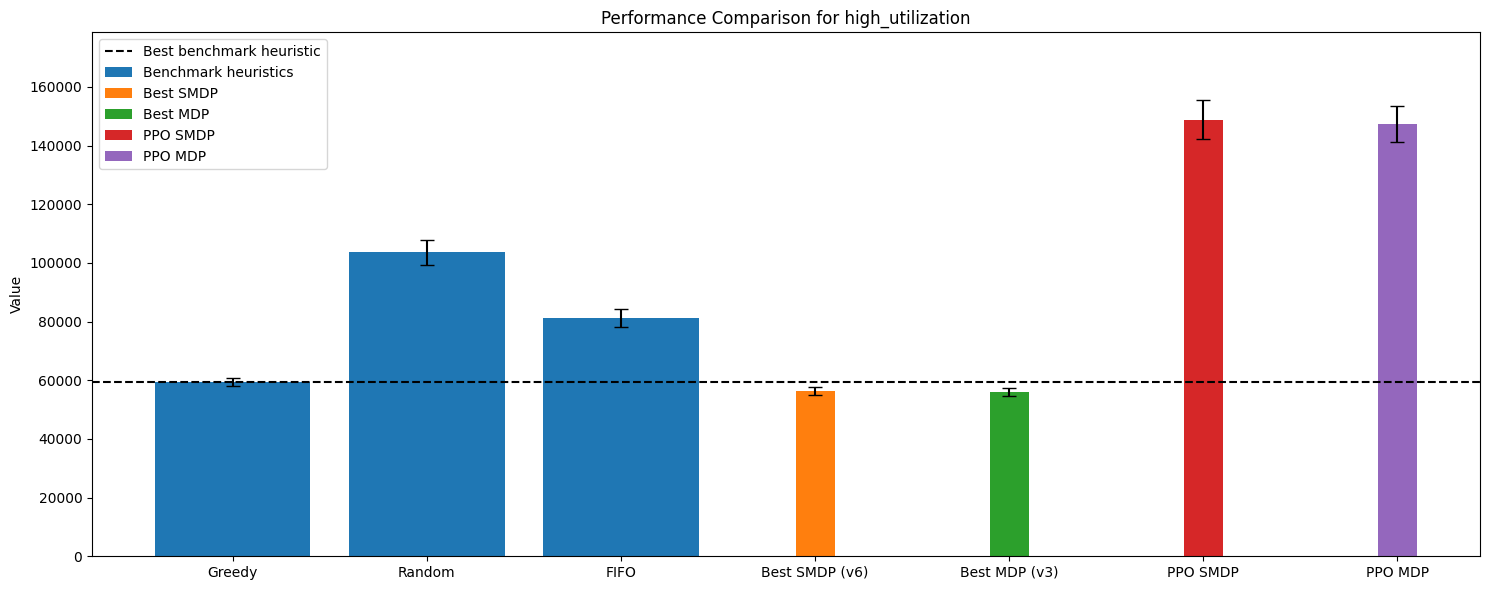

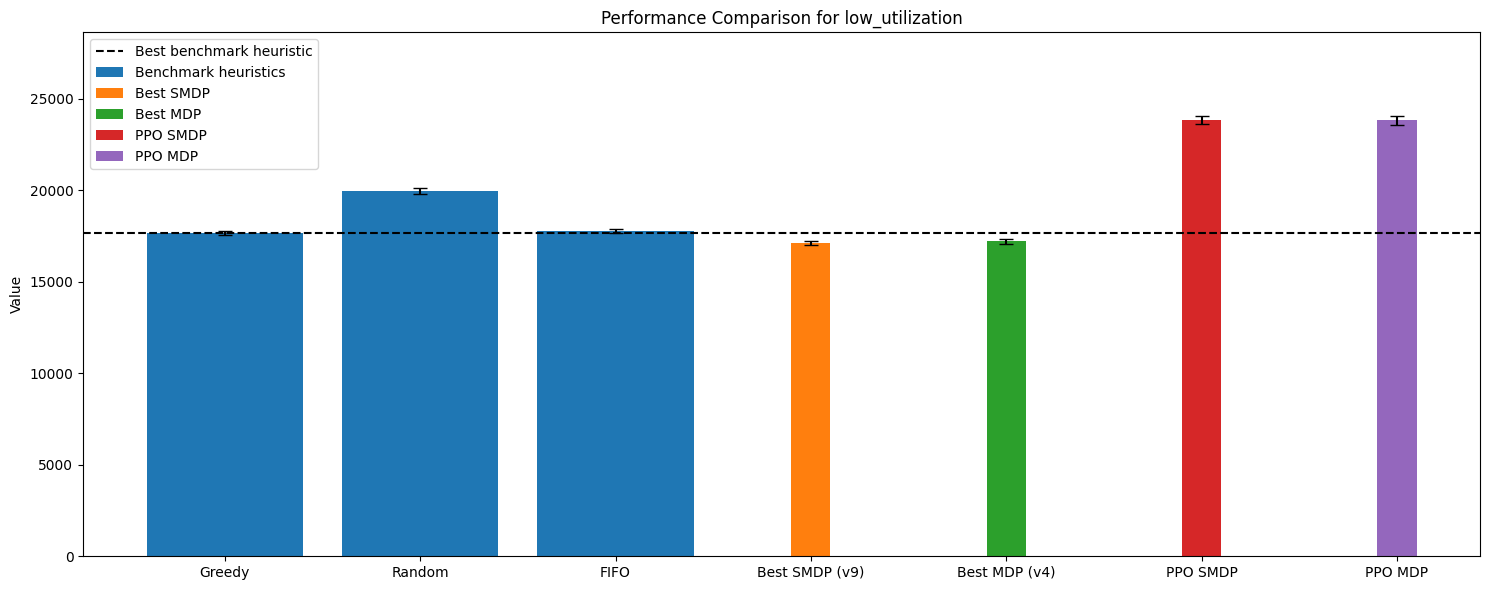

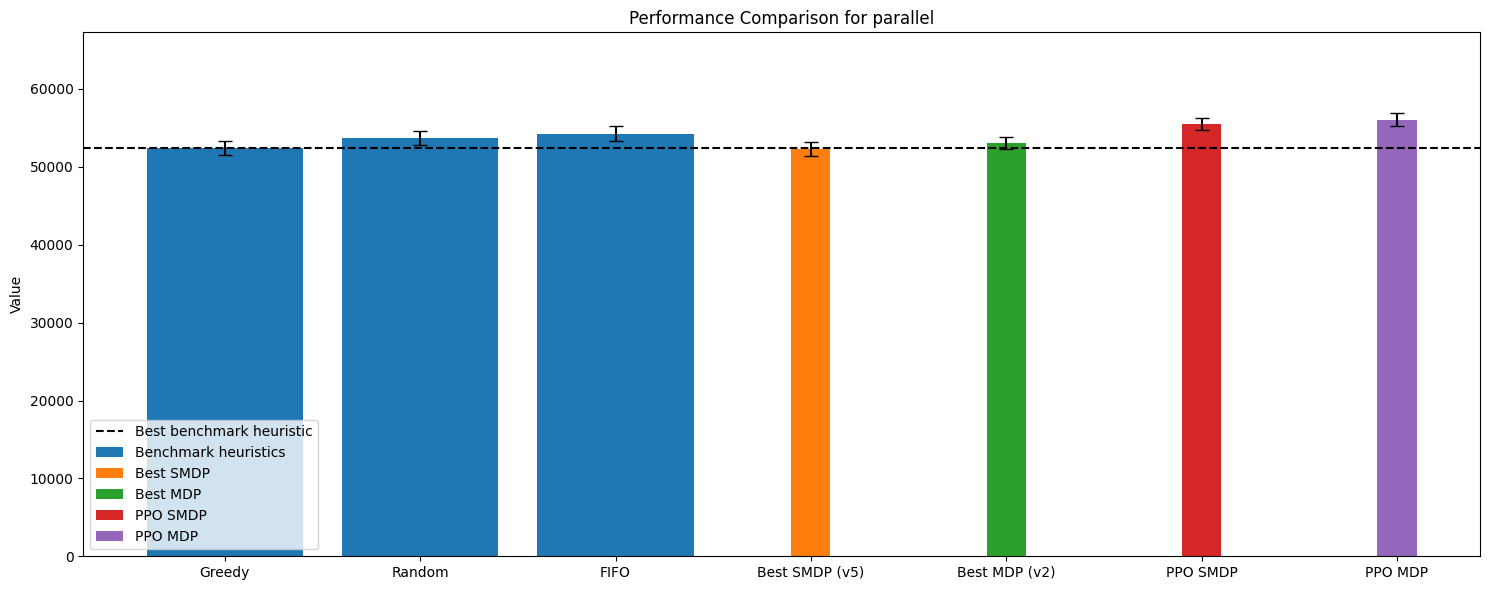

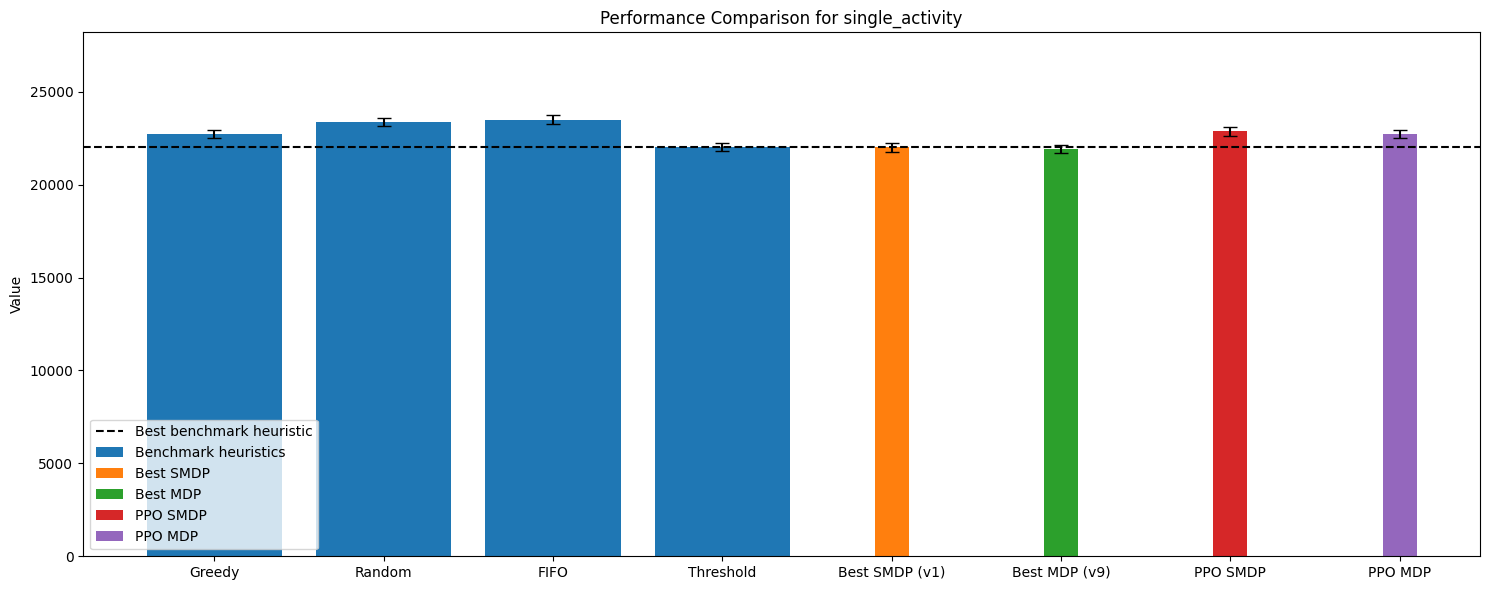

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def read_csv_with_headers(filepath):
    df = pd.read_csv(filepath, names=['Policy', 'environment', 'mean', 'std'])
    if df.columns[0] != 'Policy':
        df.columns = ['Policy', 'environment', 'mean', 'std']
    df['mean'] = df['mean'].abs()  # Change negative values to positive
    df['environment'] = df['environment'].str.strip()  # Remove leading and trailing whitespaces
    df = calculate_confidence_interval(df)
    return df

def calculate_confidence_interval(df):
    df['CI'] = 1.96 * df['std'] / np.sqrt(500)
    return df

data = {}

configs = ["slow_server", "n_system", "down_stream", "high_utilization", "low_utilization", "parallel", "single_activity"]

for config in configs:
    # Read PPO results
    ppo_mdp = pd.read_csv(f"./results/smdp/ppo/results_{config}_mdp.txt")
    ppo_mdp_mean = abs(ppo_mdp['mean'].iloc[0])
    ppo_mdp_std = ppo_mdp[' std'].iloc[0]
    ppo_mdp_ci = 1.96 * ppo_mdp_std / np.sqrt(500)
    
    ppo_smdp = pd.read_csv(f"./results/smdp/ppo/results_{config}_smdp.txt")
    ppo_smdp_mean = abs(ppo_smdp['mean'].iloc[0])
    ppo_smdp_std = ppo_smdp[' std'].iloc[0]
    ppo_smdp_ci = 1.96 * ppo_smdp_std / np.sqrt(500)
    
    data['PPO_MDP'] = (ppo_mdp_mean, ppo_mdp_ci)
    data['PPO_SMDP'] = (ppo_smdp_mean, ppo_smdp_ci)

    df = read_csv_with_headers(f"./results/smdp/results_{config}.txt")
    policies = ['Greedy', 'Random', 'FIFO']
    if config == 'single_activity':
        policies.append('Threshold')
    for policy in policies:
        df_policy = df[df['Policy'] == policy]
        data[policy] = (df_policy['mean'].iloc[0], df_policy['CI'].iloc[0])

    best_smdp = None
    best_mdp = None
    best_smdp_value = float('inf')
    best_mdp_value = float('inf')

    for environment in ['smdp', 'mdp']:
        for v in [f'v{i}' for i in range(1, 11)]:
            df_learned_v = df[(df['environment'] == environment) & (df['Policy'] == v)]
            mean_value = df_learned_v['mean'].iloc[0]
            if environment == 'smdp' and mean_value < best_smdp_value:
                best_smdp_value = mean_value
                best_smdp = (v, df_learned_v['CI'].iloc[0])
            elif environment == 'mdp' and mean_value < best_mdp_value:
                best_mdp_value = mean_value
                best_mdp = (v, df_learned_v['CI'].iloc[0])

    data[('smdp', best_smdp[0])] = (best_smdp_value, best_smdp[1])
    data[('mdp', best_mdp[0])] = (best_mdp_value, best_mdp[1])

    # Create figure
    fig, ax = plt.subplots(figsize=(15, 6))

    # Setup x-axis positions
    width = 0.2

    # Calculate x positions
    policy_positions = np.arange(len(policies))
    version_positions = np.arange(2) + len(policies)  # +1 for spacing
    ppo_positions = np.arange(2) + len(policies) + 2  # +2 for spacing

    # Plot policies
    policy_means = [data[p][0] for p in policies]
    policy_errors = [data[p][1] for p in policies]
    ax.bar(policy_positions, policy_means, yerr=policy_errors, capsize=5, label='Benchmark heuristics')

    # Plot best learned models
    smdp_mean = data[('smdp', best_smdp[0])][0]
    smdp_error = data[('smdp', best_smdp[0])][1]
    mdp_mean = data[('mdp', best_mdp[0])][0]
    mdp_error = data[('mdp', best_mdp[0])][1]

    ax.bar(version_positions[0], smdp_mean, width, yerr=smdp_error, label='Best SMDP', capsize=5)
    ax.bar(version_positions[1], mdp_mean, width, yerr=mdp_error, label='Best MDP', capsize=5)

    # Plot PPO models
    ppo_smdp_mean = data['PPO_SMDP'][0]
    ppo_smdp_error = data['PPO_SMDP'][1]
    ppo_mdp_mean = data['PPO_MDP'][0]
    ppo_mdp_error = data['PPO_MDP'][1]

    ax.bar(ppo_positions[0], ppo_smdp_mean, width, yerr=ppo_smdp_error, label='PPO SMDP', capsize=5)
    ax.bar(ppo_positions[1], ppo_mdp_mean, width, yerr=ppo_mdp_error, label='PPO MDP', capsize=5)

    ax.axhline(y=min(policy_means), color='black', linestyle='--', label='Best benchmark heuristic')
    ax.set_ylim(0, 1.2 * max(max(policy_means), ppo_mdp_mean, ppo_smdp_mean, smdp_mean, mdp_mean))

    # Set x-ticks and labels
    all_positions = np.concatenate([policy_positions, version_positions, ppo_positions])
    all_labels = policies + [f'Best SMDP ({best_smdp[0]})', f'Best MDP ({best_mdp[0]})', 'PPO SMDP', 'PPO MDP']
    ax.set_xticks(all_positions)
    ax.set_xticklabels(all_labels)

    # Add labels and legend
    ax.set_ylabel('Value')
    ax.set_title(f'Performance Comparison for {config}')
    ax.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

# Plot best results

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

policies = ['spt', 'fifo', 'random', 'threshold', 'ppo', 'pi', 'vi']
scenarios = ['slow_server', 'n_system', 'down_stream', 'high_utilization', 'low_utilization', 'parallel', 'single_activity']

for scenario in scenarios:
    df_spt = pd.read_csv(f'.results/spt_{scenario}.txt')
    df_fifo = pd.read_csv(f'.results/fifo_{scenario}.txt')
    df_random = pd.read_csv(f'.results/random_{scenario}.txt')
    if scenario == 'single_activity':
        df_threshold = pd.read_csv(f'.results/threshold_{scenario}.txt')
    df_ppo_smdp = pd.read_csv(f'.results/ppo_{scenario}_smdp.txt')
    df_ppo_mdp = pd.read_csv(f'.results/ppo_{scenario}_mdp.txt')
    df_pi_smdp = pd.read_csv(f'.results/pi_{scenario}_smdp.txt')
    df_pi_mdp = pd.read_csv(f'.results/pi_{scenario}_mdp.txt')
    df_vi = pd.read_csv(f'.results/vi_{scenario}.txt')

AttributeError: partially initialized module 'pandas' has no attribute '_pandas_parser_CAPI' (most likely due to a circular import)